# Phys 41 Final Project: Metropolis-Hastings Monte Carlo (Jake Anderson)

This project implements and explains the Metropolis-Hastings algorithm for Markov Chain Monte Carlo (MCMC).

In [1]:
import IPython
import matplotlib.pyplot as plt
import numpy as np
import sympy

## Multiple integrals

A typical definite integral of a function $f(x)$ over domain $D$ can be written as $\int_{D}f(x)\;dx$, where $x\in\mathbb{R}^1$ and $D\in\mathbb{R}^1$. This can be extended to integrate functions of $n$ inputs, which are written as
$$\int_{D_n}\cdots\int_{D_1}f(x_1,\dots x_n)\;dx_1\cdots dx_n\;,$$
where $\left( x_1, \dots, x_n \right) \in \mathbb{R}^n$ and $\lbrace D_1,\dots,D_n \rbrace\subset\mathbb{R}^1$. In this project, visual examples will use functions of one variable, but integrals in higher dimensions will be evaluated using the same code. This is because it's simply too difficult to visualize data involving functions $f(x_1,\dots,x_n)$ where $n\gt2$.

## Example 1
Let's say one wants to evaluate the integral of $f(x)=\sqrt{x}$ on the domain $0\leq x\leq4$ and does so analytically. This integral can be written as
$$\int_{0}^{4}\sqrt{x}\;dx$$
As any single-variable calculus student could tell you, $\int\sqrt{x}\;dx=\frac{2}{3}x^{3/2}$, and our definite integral becomes
$$\frac{2}{3}x^{3/2}\,\Bigg\rvert_{0}^{4}=\frac{2}{3}\left[ 4^{3/2} - 0^{3/2} \right]=\frac{16}{3}=5.\bar{3}$$

Instead of calculating this definite integral analytically, it can be approximated numerically using simple Riemann summation:

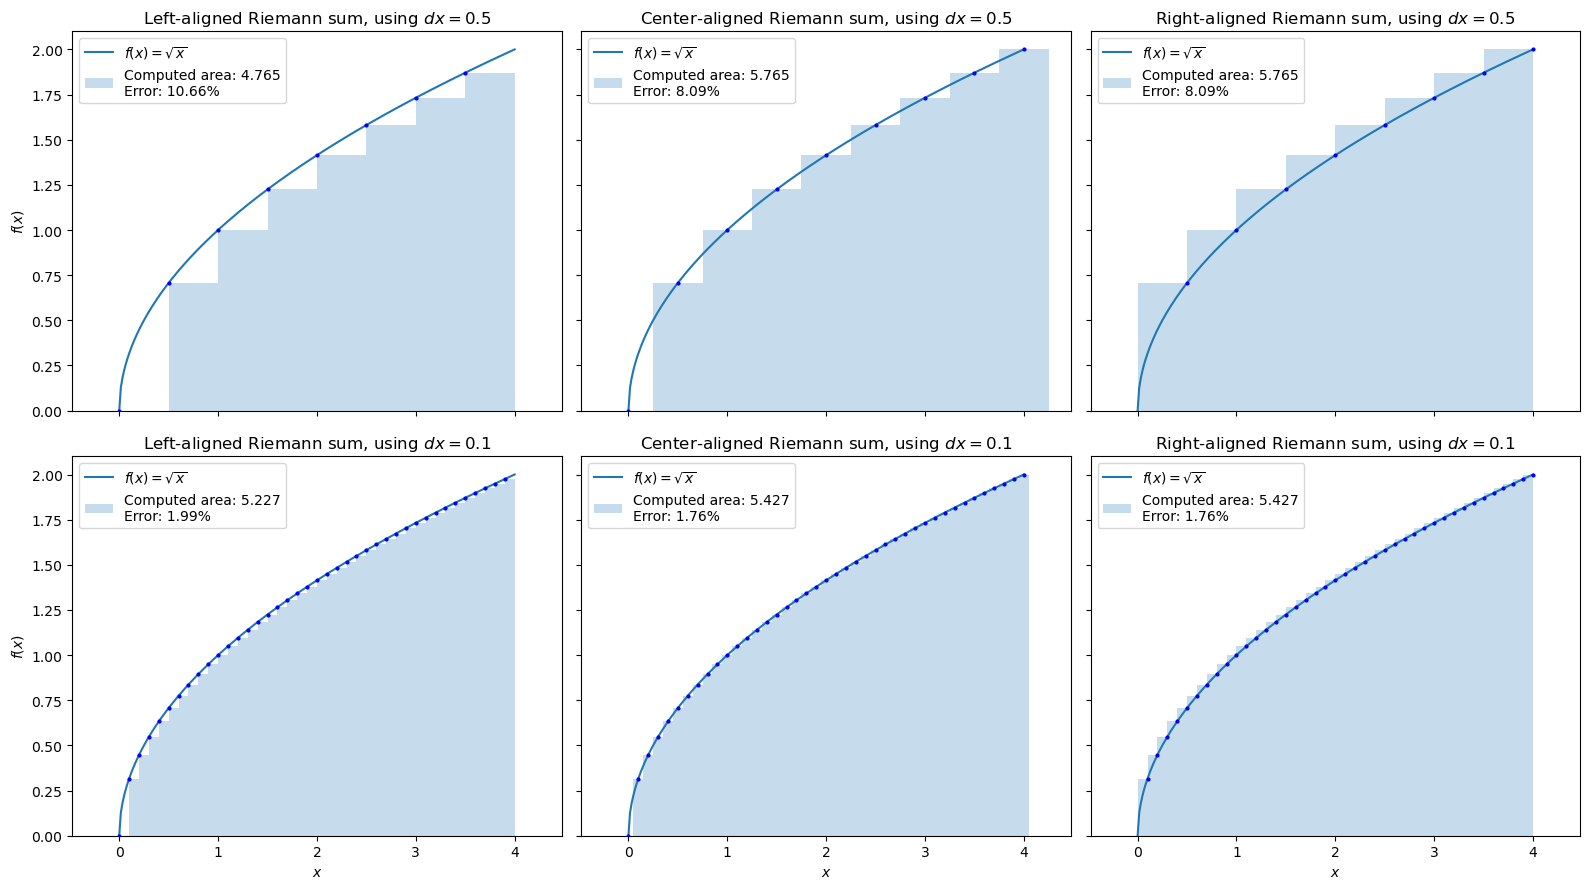

In [2]:
nrows, ncols = (2, 3)
fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(16, 9), sharex=True, sharey=True
)

# Create lists of indices to automatically map to different subplots
j_indices, i_indices = np.meshgrid(np.arange(0, ncols), np.arange(0, nrows))
i_indices = i_indices.flatten()
j_indices = j_indices.flatten()

for i in range(0, len(i_indices)):
    # Pick the proper axis (subplot)
    ax = axes[i_indices[i]][j_indices[i]]
    domain = np.linspace(0, 4, 250)
    ax.plot(domain, np.sqrt(domain), label=r"$f(x)=\sqrt{x}$")

    # Depending on the subplot, use a different dx
    if i in range(0, int(len(i_indices) / 2)):
        dx = 0.5
    else:
        dx = 0.1

    # Depending on the subplot, use a different Riemann sum alignment
    if i % 3 == 0:
        alignment = "edge"
        domain = np.arange(0, 4, dx)
        width = dx
        ax.set_title(f"Left-aligned Riemann sum, using $dx={dx:0.1f}$")
    elif i % 3 == 1:
        alignment = "center"
        domain = np.arange(0, 4 + dx, dx)
        width = dx
        ax.set_title(f"Center-aligned Riemann sum, using $dx={dx:0.1f}$")
    else:
        alignment = "edge"
        domain = np.arange(0 + dx, 4 + dx, dx)
        width = -1 * dx
        ax.set_title(f"Right-aligned Riemann sum, using $dx={dx:0.1f}$")

    # Compute the integral by summing the rectangles' areas
    heights = np.sqrt(domain)
    val = np.sum(heights * dx)

    label = f"Computed area: {val:0.3f}\nError: {100*abs((val-(16/3))/(16/3)):0.2f}%"
    ax.bar(domain, heights, width=width, align=alignment, alpha=0.25, label=label)
    ax.scatter(domain, heights, color="blue", zorder=50, s=4)
    if i % 3 == 0:
        ax.set_ylabel("$f(x)$")
    if i >= 3:
        ax.set_xlabel("$x$")
    ax.legend()

fig.tight_layout()
fig.show()

Notice that as we decrease the width of each rectangle, the numerical approximation $S=\sum_{x\in\lbrace0,dx,2dx,\dots4/dx\rbrace} f(x)\;dx$ (assuming centered Riemann summation) approaches our analytical value of $\frac{16}{3}$ and has an increasingly small error. In fact, by the definition of the derivative, $\lim_{dx\rightarrow0}S\equiv\int_{0}^{4}\sqrt{x}\;dx=\frac{16}{3}$.

In [3]:
dx = 1e-4
domain = np.arange(0, 4 + dx, dx)
val = np.sum((lambda x: np.sqrt(x))(domain) * dx)
print(
    f"Using dx={dx}, we get that the integral equals {val:0.5f}. This is an error of only {100*abs(val-(16/3))/(16/3):0.4f}%"
)

Using dx=0.0001, we get that the integral equals 5.33343. This is an error of only 0.0019%


## Example 2

Let's say one wants to evaluate the integral of $f(x)=\sin(x)\sqrt{x}$ on the domain $0\leq x\leq8\pi$, written as:
$$\int_{0}^{8\pi}\sin(x)\sqrt{x}\;dx$$
This is a much more challenging integral to solve analytically, so numeric approximation of any kind is especially useful here. Here is what an analytical solution to this integral would look like.

In [4]:
# Use sympy to evaluate the integral analytically and solve it numerically (using Gaussian quadrature)
x = sympy.Symbol("x")

print("Indefinite integral:")
integral = sympy.integrate(sympy.sin(x) * sympy.sqrt(x), (x))
IPython.display.display(integral)

print("\nDefinite integral:")
integral = sympy.integrate(sympy.sin(x) * sympy.sqrt(x), (x, 0, 8 * sympy.pi))
IPython.display.display(integral)
reference_val = integral.evalf()
print(f"which evaluates to {reference_val}")

Indefinite integral:


-5*sqrt(x)*cos(x)*gamma(5/4)/(4*gamma(9/4)) + 5*sqrt(2)*sqrt(pi)*fresnelc(sqrt(2)*sqrt(x)/sqrt(pi))*gamma(5/4)/(8*gamma(9/4))


Definite integral:


-5*sqrt(2)*sqrt(pi)*gamma(5/4)/(2*gamma(9/4)) + 5*sqrt(2)*sqrt(pi)*fresnelc(4)*gamma(5/4)/(8*gamma(9/4))

which evaluates to -4.38857215564917


Let's re-use the code from before and see how well Riemann approximation fares.

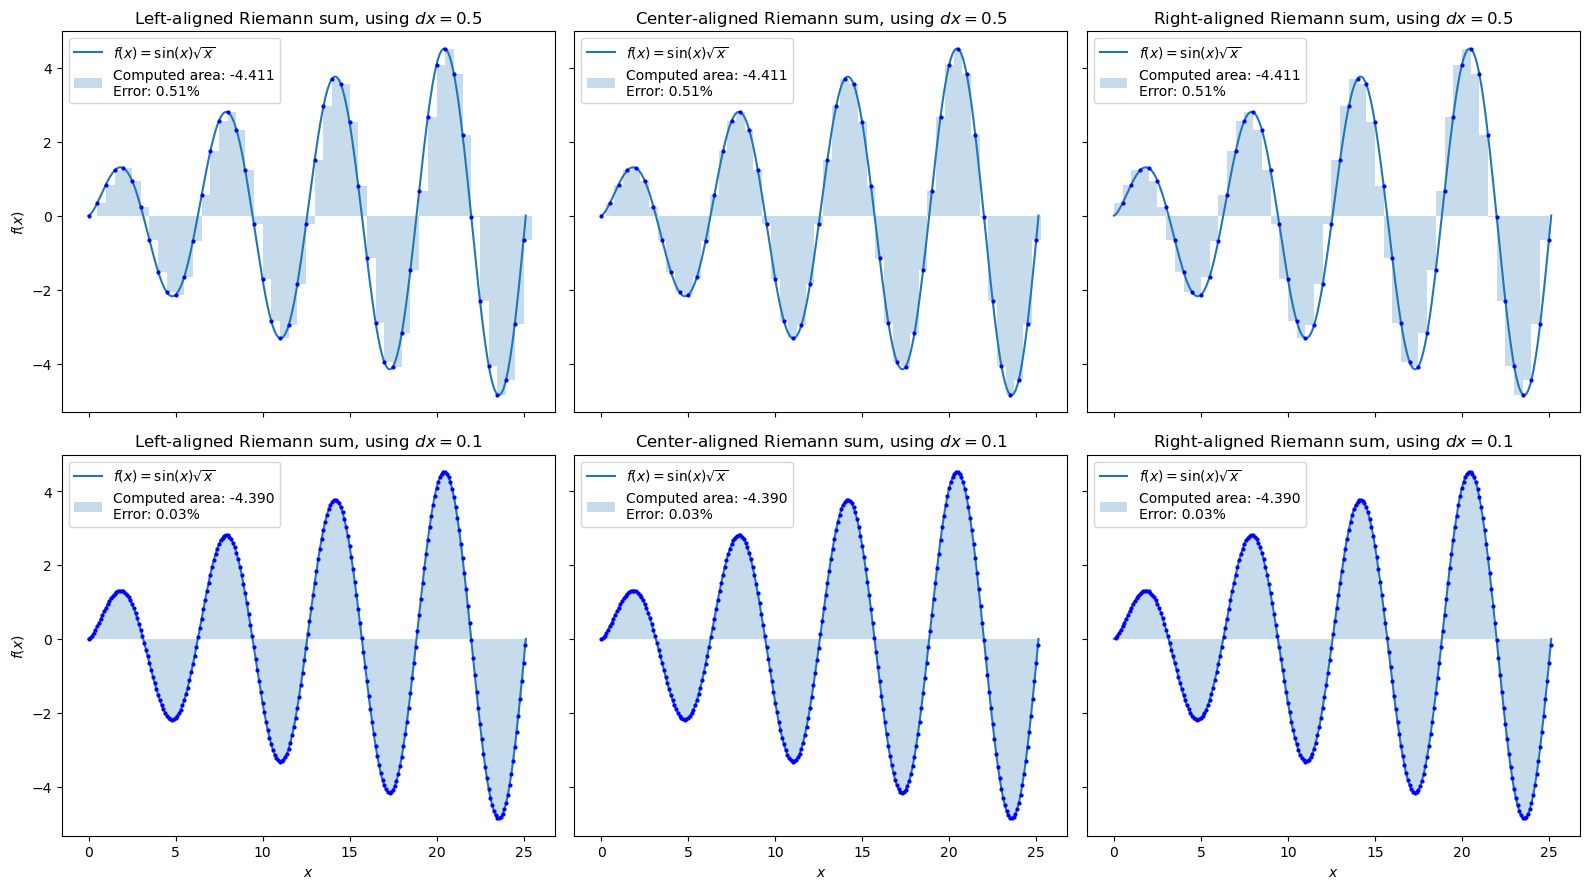

In [5]:
nrows, ncols = (2, 3)
fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(16, 9), sharex=True, sharey=True
)

j_indices, i_indices = np.meshgrid(np.arange(0, ncols), np.arange(0, nrows))
i_indices = i_indices.flatten()
j_indices = j_indices.flatten()

for i in range(0, len(i_indices)):
    ax = axes[i_indices[i]][j_indices[i]]
    domain = np.linspace(0, 8 * np.pi, 250)
    ax.plot(domain, np.sin(domain) * np.sqrt(domain), label=r"$f(x)=\sin(x)\sqrt{x}$")

    if i in range(0, int(len(i_indices) / 2)):
        dx = 0.5
    else:
        dx = 0.1

    if i % 3 == 0:
        alignment = "edge"
        domain = np.arange(0, 8 * np.pi, dx)
        width = dx
        ax.set_title(f"Left-aligned Riemann sum, using $dx={dx:0.1f}$")
    elif i % 3 == 1:
        alignment = "center"
        domain = np.arange(0, 8 * np.pi + 1e-4, dx)
        width = dx
        ax.set_title(f"Center-aligned Riemann sum, using $dx={dx:0.1f}$")
    else:
        alignment = "edge"
        domain = np.arange(0 + dx, 8 * np.pi, dx)
        width = -1 * dx
        ax.set_title(f"Right-aligned Riemann sum, using $dx={dx:0.1f}$")

    heights = np.sin(domain) * np.sqrt(domain)
    val = np.sum(heights * dx)
    label = f"Computed area: {val:0.3f}\nError: {100*abs((val-reference_val)/reference_val):0.2f}%"
    ax.bar(domain, heights, width=width, align=alignment, alpha=0.25, label=label)
    ax.scatter(domain, heights, color="blue", zorder=50, s=4)
    if i % 3 == 0:
        ax.set_ylabel("$f(x)$")
    if i >= 3:
        ax.set_xlabel("$x$")
    ax.legend()

fig.tight_layout()
fig.show()

## Example 3

Now let's say one wants to find the integral of $f(x)=\frac{10}{x}$ on the domain $1\leq x\leq30$. We can of course write this integral as:
$$\int_1^{30}\frac{10}{x}\;dx=10\log|x|\,\Bigg|_1^{30}=10\left[ \log(30) - \log(1) \right]\approx34.01197$$
If we evenly space numbers like we have been doing, we notice something interesting.

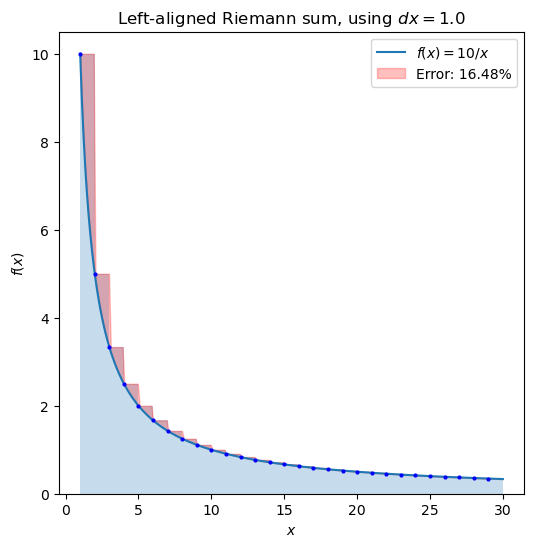

In [6]:
reference_val = 10 * np.log(30)
fig = plt.figure(figsize=(6, 6))

# Create a fine list of x values for plotting the smooth curves. Won't be used in integration
smooth_domain = np.linspace(1, 30, 250)
plt.plot(smooth_domain, 10 / smooth_domain, label="$f(x)=10/x$")

dx = 1.0
domain = np.arange(1, 30, dx)
heights = 10 / domain
val = np.sum(heights * dx)
plt.bar(domain, heights, width=dx, align="edge", alpha=0.25, label=f"")
plt.scatter(domain, heights, color="blue", zorder=50, s=4)


def bar_height(xs):
    return np.array(
        [heights[-1] if x == xs[-1] else heights[int(x // dx - 1)] for x in xs]
    )


# Highlight differences between the rectangles and the the actual curve in red
plt.fill_between(
    smooth_domain,
    10 / smooth_domain,
    bar_height(smooth_domain),
    color="red",
    alpha=0.25,
    label=f"Error: {100*abs((val-reference_val)/reference_val):0.2f}%",
)
plt.ylabel("$f(x)$")
plt.xlabel("$x$")
plt.title(f"Left-aligned Riemann sum, using $dx={dx}$")
plt.legend()
fig.show()

Notice that more error, or deviation from the analytical curve, occurs at sections of the curve with higher values. What can we do to fix this? Maybe instead of choosing uniformly spaced $x$ values, we could choose $x$ values that correlate with the distribution of the curve we're integrating. Let's choose 30 random values on the interval $\left[ 0, 30 \right]$ as our $x$ values. On the left we'll get these values by sampling a uniform distribution, and on the right we'll get these values by sampling the distribution $P(x)\propto\frac{10}{x}$. We'll choose $P(x)=\frac{1}{x}$.

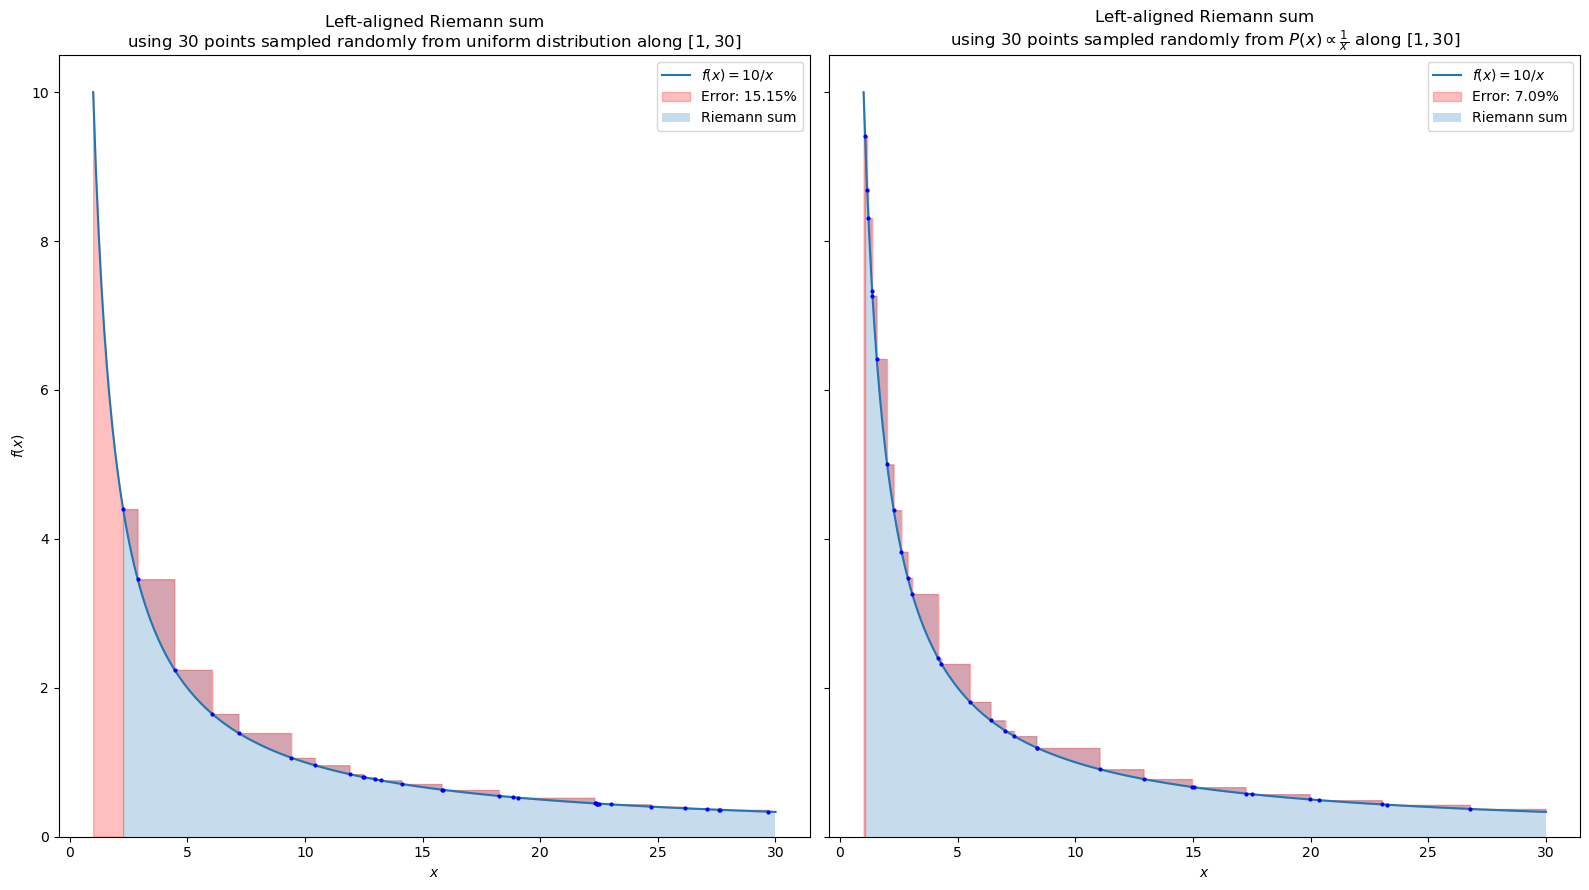

In [7]:
reference_val = 10 * np.log(30)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 9), sharey=True)
rng = np.random.default_rng(seed=24680)

num_points = 30
smooth_domain = np.linspace(1, 30, 250)
axes[0].plot(smooth_domain, 10 / smooth_domain, label="$f(x)=10/x$")
axes[1].plot(smooth_domain, 10 / smooth_domain, label="$f(x)=10/x$")

domain = np.sort(rng.uniform(low=1, high=30, size=num_points))
heights = 10 / domain
heights = heights
widths = []
for i, x in enumerate(domain):
    if x == domain[-1]:
        widths.append(30 - x)
    else:
        widths.append(domain[i + 1] - domain[i])

val = np.sum(widths * heights)
axes[0].bar(
    domain, heights, width=widths, align="edge", alpha=0.25, label=f"Riemann sum"
)
axes[0].scatter(domain, heights, color="blue", zorder=50, s=4)
for i, x in enumerate(domain):
    subdomain = np.linspace(x, x + widths[i], 100)
    axes[0].fill_between(
        subdomain,
        10 / subdomain,
        [heights[i] for _ in subdomain],
        color="red",
        alpha=0.25,
    )

subdomain = np.linspace(1, domain[0])
axes[0].fill_between(
    subdomain,
    10 / subdomain,
    [0 for _ in subdomain],
    color="red",
    alpha=0.25,
    label=f"Error: {100*abs((val-reference_val)/reference_val):0.2f}%",
)
axes[0].legend()
axes[0].set_ylabel("$f(x)$")
axes[0].set_xlabel("$x$")
axes[0].set_title(
    f"Left-aligned Riemann sum\nusing {num_points} points sampled randomly from uniform distribution along $\\left[ 1,30 \\right]$"
)

domain = []
# This is crude importance sampling using two samples from uniform distributions.
# This is just like when we created samples from a Poisson distribution in Homework #3.
while len(domain) < num_points:
    x = rng.uniform(
        low=1,
        high=30,
    )
    y = 1 / x
    y_temp = rng.random()
    if y_temp < y:
        domain.append(x)

domain = np.sort(np.array(domain))
heights = 10 / domain
widths = []
for i, x in enumerate(domain):
    if x == domain[-1]:
        widths.append(30 - x)
    else:
        widths.append(domain[i + 1] - domain[i])

val = np.sum(widths * heights)
axes[1].bar(
    domain, heights, width=widths, align="edge", lw=5, alpha=0.25, label=f"Riemann sum"
)
axes[1].scatter(domain, heights, color="blue", zorder=50, s=4)
for i, x in enumerate(domain):
    subdomain = np.linspace(x, x + widths[i], 100)
    axes[1].fill_between(
        subdomain,
        10 / subdomain,
        [heights[i] for _ in subdomain],
        color="red",
        alpha=0.25,
    )

subdomain = np.linspace(1, domain[0])
axes[1].fill_between(
    subdomain,
    10 / subdomain,
    [0 for _ in subdomain],
    color="red",
    alpha=0.25,
    label=f"Error: {100*abs((val-reference_val)/reference_val):0.2f}%",
)
axes[1].legend()
axes[1].set_xlabel("$x$")
axes[1].set_title(
    f"Left-aligned Riemann sum\nusing {num_points} points sampled randomly from $P(x)\\propto\\frac{{1}}{{x}}$ along $\\left[ 1,30 \\right]$"
)


fig.tight_layout()
fig.show()

Both integral approximations used the same number of points, but by carefully choosing which points to sample we capture more of the curve's detail and therefore get a better approximation. This technique of using more points where we have more "interesting" features of the curve is called **importance sampling**. In this case, since we're doing an integration, we are interested in the parts of the curve that have high values. The intuition here is that if we were to choose where on the curve to sample more densely, we would see the greatest decrease in overall error if we choose parts of the curve that have the highest values.

But where did our $P(x)$ come from? We know that $P(x)$ ought to be proportional to $f(x)=\frac{1}{x}$, but should $P(x)$ be $\frac{1}{x}$ as used above? Why not $\frac{50\,000}{x}$? Or how about $\frac{0.001}{x}$? Any of these distributions will eventually (if $n$ is very large) get us $n$ values distributed properly along $f(x)$, but the time it takes to get those $n$ values is dependent on our choice of $P(x)$. Let's compare some choices of $P(x)$.

In [8]:
import time

reference_val = 10 * np.log(30)
num_points = 1000
p_numerators = [1, 50000, 0.001]
for p_numerator in p_numerators:
    domain = []
    counter = 0

    # Start timer
    start = time.process_time()
    while len(domain) < num_points:
        counter += 1
        x = rng.uniform(
            low=1,
            high=30,
        )
        y = p_numerator / x
        y_temp = rng.random()
        if y_temp < y:
            domain.append(x)
    # End timer
    stop = time.process_time()
    elapsed_time = stop - start

    domain = np.sort(np.array(domain))
    heights = 10 / domain
    widths = []
    for i, x in enumerate(domain):
        if x == domain[-1]:
            widths.append(30 - x)
        else:
            widths.append(domain[i + 1] - domain[i])

    val = np.sum(widths * heights)
    error = 100 * abs((val - reference_val) / reference_val)
    print(
        f"\nUsing {num_points} points sampled from P(x)={p_numerator}/x, we approximate the integral from 1 to 30 of 10/x with an error of {error:0.2f}%."
    )
    print(
        f"Sampling these points took {elapsed_time:0.3} seconds. The average time per valid sample was {elapsed_time/num_points:0.3} seconds."
    )
    print(
        f'{counter} points were tried, of which {num_points} were accepted as sample values. This means there were {counter-num_points} "wasted" values.\n'
    )


Using 1000 points sampled from P(x)=1/x, we approximate the integral from 1 to 30 of 10/x with an error of 0.20%.
Sampling these points took 0.0168 seconds. The average time per valid sample was 1.68e-05 seconds.
8489 points were tried, of which 1000 were accepted as sample values. This means there were 7489 "wasted" values.


Using 1000 points sampled from P(x)=50000/x, we approximate the integral from 1 to 30 of 10/x with an error of 0.45%.
Sampling these points took 0.002 seconds. The average time per valid sample was 2e-06 seconds.
1000 points were tried, of which 1000 were accepted as sample values. This means there were 0 "wasted" values.


Using 1000 points sampled from P(x)=0.001/x, we approximate the integral from 1 to 30 of 10/x with an error of 0.15%.
Sampling these points took 16.7 seconds. The average time per valid sample was 0.0167 seconds.
8827890 points were tried, of which 1000 were accepted as sample values. This means there were 8826890 "wasted" values.



We see that when the numerator of $P(x)$ is too big, *all* of our candidate values sampled from the uniform distribution on $\left[ 1,30 \right]$ were accepted and our resulting distrubition is uniform, not proportional to $\frac{10}{x}$ at all. That is what causes the increased error relative to the other numerators.

When the numerator of $P(x)$ is too small, we get a decent approximation, but we waste much time trying out points that don't end up being used. This is where adaptive acceptance ratio Metropolis-Hastings can help.

## Metropolis-Hastings

Here is what we have been doing in our crude importance sampling:

 1. Scale $f(x)$ by an arbitrary amount to get $P(x)$.
 2. Sample a random candidate value $a$ from the uniform distribution on the domain $D$.
 3. Sample a comparison value $b$ from the uniform distribution on the domain $\left[ 0,1 \right]$.
 4. If $f(a)\gt b$, we add $a$ to our growing list of "important" samples. If not, we discard $a$ and proceed to Step 2.
 5. If our list of samples has not yet met our length requirement, we proceed to Step 2.

In Metropolis-Hastings Monte Carlo, which can be thought of as a smarter type of importance sampling, we do the following:

 1. Choose a function $g(x^\prime|x)$. We will use the Gaussian distribution centered on $x$ with standard deviation $1$: $g(x^\prime|x)=\left(1/\sqrt{2\pi}\right)\exp\left( -\frac{1}{2}\left( x^\prime-x \right)^2 \right)$.
 2. Set $t=0$ and find $x_t$ when $t=0$. Here we will get $x_0$ by sampling from the uniform distribution on the domain $D$, but one could just as well set $x_0$ to be, for example, the midpoint of $D$.
 3. Sample a random candidate value $x^\prime$ from $g(x^\prime|x_t)$.
 4. Calculate the probability of accepting this candidate $A(x^\prime,x_t)=\min\left(1, \frac{|f(x^\prime)|}{|f(x_t)|} \frac{g(x_t|x^\prime)}{g(x^\prime|x_t)} \right)$.
 5. Sample a random comparison value $b$ from the uniform distribution on the domain $\left[ 0,1 \right]$. If $b\leq A(x^\prime,x_t)$, we accept the new state, set $x_{t+1}=x^\prime$ and increment $t$ by one. Otherwise, we reject the new state and set $x_{t+1}=x_t$ and increment $t$ by one.
 6. If $t$ has not yet met our required value, we proceed to Step 3.

If we want to use adaptive acceptance ratio Metropolis-Hastings, we simply run Metropolis-Hastings for a while and vary the standard deviation parameter in $g(x^\prime|x)$ until some criterion is met, often that 10% to 50% of the last $m$ candidate values were accepted. For brevity's sake, $g(x^\prime|x)$ is kept unchanged throughout the sampling in this project.

Metropolis-Hastings provides us with an arbitrary number of values $\lbrace x,\cdots, x_n \rbrace$ and their corresponding values of $f(x)$, $\lbrace f(x),\cdots, f(x_n) \rbrace$, that are biased toward the largest values of $f(x)$. Biasing toward the largest values of $f(x)$ is exactly what we defined earlier as importance sampling! The list of points of the form $\left( x,f(x) \right)$ can simply be used as vertices for numeric integration methods like Riemann summation.

[This Wikipedia article](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) was used as a reference for the Metropolis-Hastings algorithm. One change to note is that while this description of the MH algorithm defines the acceptance ratio $A$ as $A(x^\prime,x_t)=\min\left(1, \frac{f(x^\prime)}{f(x_t)} \frac{g(x_t|x^\prime)}{g(x^\prime|x_t)} \right)$, we use the absolute value of $f$, ensuring we get dense sampling at function maxima *and mimima*: $A(x^\prime,x_t)=\min\left(1, \frac{|f(x^\prime)|}{|f(x_t)|} \frac{g(x_t|x^\prime)}{g(x^\prime|x_t)} \right)$.

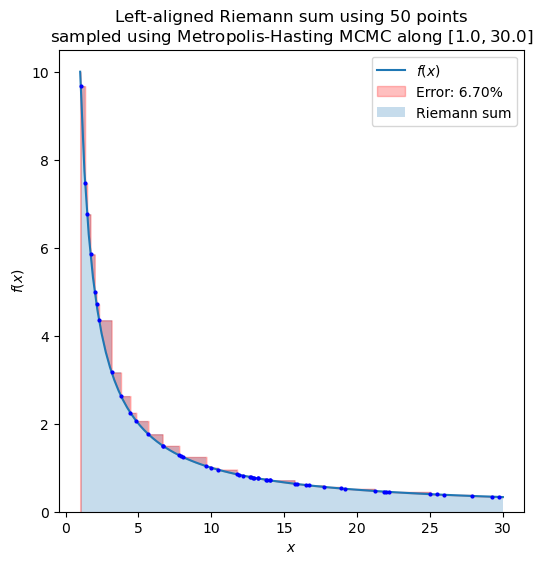

In [9]:
def run_and_plot_MHMC(f, g, domain, reference_val, num_points=50, plot=False):
    """
    This function takes an integrand f(x) (1D), the proposal distribution g(x) (1D),
    the domain of x (a duple of floats), a reference value, (optionally) an integer
    number of points, and whether or not to create plots.

    It performs MHMC, obtaining num_points samples and the values of f(x) at those samples,
    then computes and plots the left-aligned Riemann approximation of the integral of f(x)
    on the domain.

    It returns a tuple of the float value of the approximated integral, a list of the
    acceptance ratios A, and the total number of steps taken to get num_points samples.
    """

    rng = np.random.default_rng(seed=135791)
    x_0 = rng.uniform(low=1, high=30)
    t = 0
    samples = [x_0]
    heights = [f(x_0, domain)]
    # Keep record of the A values, in case g needs to be tuned to lower/raise average A
    As = []

    while len(set(samples)) < num_points:
        x_prime = g(samples[t], rng)
        height = f(x_prime, domain)
        numerator = abs(height) * g(x_prime, rng, x_prime=samples[t])
        denominator = abs(heights[t]) * g(samples[t], rng, x_prime=x_prime)
        A = min(1, numerator / denominator)
        As.append(A)
        b = rng.random()
        if b <= A:
            # Accept the new point x_prime
            samples.append(x_prime)
            heights.append(height)
        else:
            # Reject the new point x_prime
            # and repeat the last point
            samples.append(samples[t])
            heights.append(heights[t])
        t += 1

    # Remove duplicate samples
    temp_samples = []
    [temp_samples.append(sample) for sample in samples if sample not in temp_samples]
    samples = temp_samples

    # Remove duplicate heights
    temp_heights = []
    [temp_heights.append(height) for height in heights if height not in temp_heights]
    heights = temp_heights

    # Sort the samples and heights by increasing x to calculate rectangle widths easily
    samples_and_heights = list(zip(samples, heights))
    samples_and_heights.sort(key=(lambda point: point[0]))

    widths = []
    for i, (sample, height) in enumerate(samples_and_heights):
        if sample == samples_and_heights[-1][0]:
            widths.append(domain[1] - sample)
        else:
            widths.append(samples_and_heights[i + 1][0] - sample)

    # Compute the integral
    val = sum(
        [
            widths[i] * samples_and_heights[i][1]
            for i in range(0, len(samples_and_heights))
        ]
    )

    if plot:
        fig = plt.figure(figsize=(6, 6))
        smooth_domain = np.linspace(domain[0], domain[1], 100)
        plt.plot(
            smooth_domain,
            [f(x, domain) for x in smooth_domain],
            label="$f(x)$",
        )
        plt.bar(
            [point[0] for point in samples_and_heights],
            height=[point[1] for point in samples_and_heights],
            width=widths,
            align="edge",
            alpha=0.25,
            label="Riemann sum",
        )

        for i, point in enumerate(samples_and_heights):
            subdomain = np.linspace(point[0], point[0] + widths[i], 100)
            plt.fill_between(
                subdomain,
                [f(x, domain) for x in subdomain],
                [point[1] for _ in subdomain],
                color="red",
                alpha=0.25,
            )

        subdomain = np.linspace(domain[0], samples_and_heights[0][0], 100)
        plt.fill_between(
            subdomain,
            [f(x, domain) for x in subdomain],
            [0 for _ in subdomain],
            color="red",
            alpha=0.25,
            label=f"Error: {100*abs((val-reference_val)/reference_val):0.2f}%",
        )

        plt.scatter(
            [point[0] for point in samples_and_heights],
            [point[1] for point in samples_and_heights],
            color="blue",
            zorder=50,
            s=4,
        )

        plt.xlabel("$x$")
        plt.ylabel("$f(x)$")
        plt.title(
            f"Left-aligned Riemann sum using {num_points} points\nsampled using Metropolis-Hasting MCMC along $\\left[ {domain[0]:0.1f},{domain[1]:0.1f} \\right]$"
        )
        plt.legend()

    return (val, As, t)


# This is our integrand. If the candidate x is out of our domain, we return 0
# to make A 0, ensuring that point is not chosen.
def f(x, domain):
    if domain[0] <= x <= domain[1]:
        return 10 / x
    else:
        return 0


# This g uses a Gaussian distribution with the sigma set to 16.
# That value was determined by hand-tuning so that the average A is around ~0.4. (See next cell)
def g(x_t, rng, x_prime=None):
    sigma = 15
    if x_prime is None:
        return rng.normal(loc=x_t, scale=sigma)
    else:
        return np.exp(-0.5 * ((x_prime - x_t) / sigma) ** 2) / (
            sigma * np.sqrt(2 * np.pi)
        )


result = run_and_plot_MHMC(f, g, (1, 30), 10 * np.log(30), num_points=50, plot=True)

Our proposal distribution $g$ can be made wider or smaller by controlling the standard deviation parameter $\sigma$. Let's see what happens as we vary this parameter.

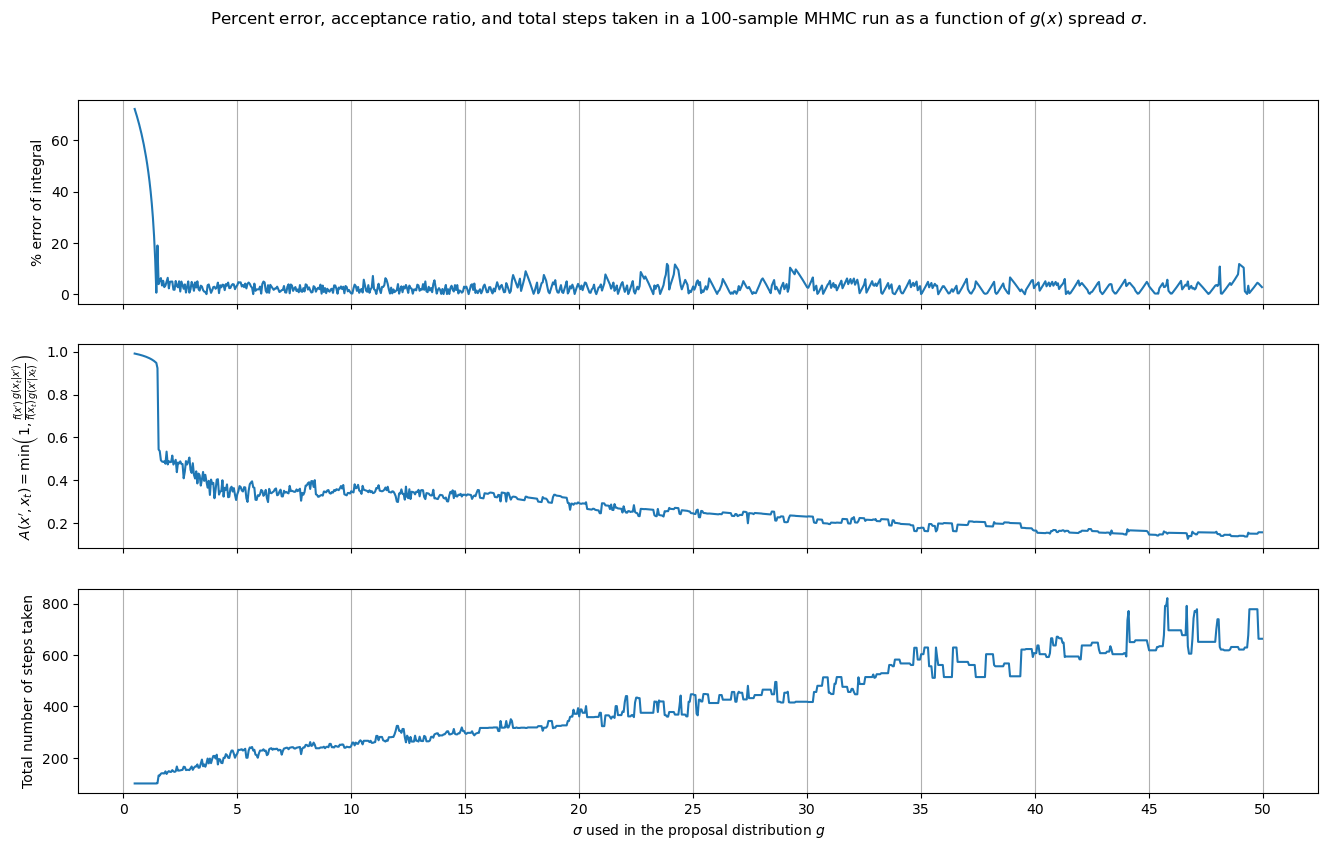

In [10]:
sigma_values = np.arange(0.5, 50, 0.05)

results = []
for sigma in sigma_values:

    def g(x_t, rng, x_prime=None):
        if x_prime is None:
            return rng.normal(loc=x_t, scale=sigma)
        else:
            return np.exp(-0.5 * ((x_prime - x_t) / sigma) ** 2) / (
                sigma * np.sqrt(2 * np.pi)
            )

    result = run_and_plot_MHMC(
        f, g, (1, 30), 10 * np.log(30), num_points=100, plot=False
    )
    results.append(result)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 9), sharex=True)
axes[0].plot(
    sigma_values, [100 * abs((result[0] - reference_val) / val) for result in results]
)
axes[0].set_ylabel("% error of integral")
axes[0].grid(axis="x")

axes[1].plot(
    sigma_values,
    [np.mean(result[1][int(len(result[1]) / 2) : -1]) for result in results],
)
axes[1].set_ylabel(
    r"$A(x^\prime,x_t)=\min\left(1, \frac{f(x^\prime)}{f(x_t)} \frac{g(x_t|x^\prime)}{g(x^\prime|x_t)} \right)$"
)
axes[1].grid(axis="x")

axes[2].plot(sigma_values, [result[2] for result in results])
axes[2].set_ylabel("Total number of steps taken")
axes[2].grid(axis="x")
axes[2].set_xlabel("$\\sigma$ used in the proposal distribution $g$")
plt.xticks(np.arange(0, 51, 5))
plt.suptitle(
    "Percent error, acceptance ratio, and total steps taken in a 100-sample MHMC run as a function of $g(x)$ spread $\\sigma$."
)
fig.show()

Since the time taken to run MHMC is proportional to the total number of steps taken, we should choose the smallest value of $\sigma$ that gives an acceptance ratio around 0.2-0.4 and a small percent error. It seems that $\sigma=5$ would be a good choice for running MHMC with this $f(x)$.

## Example 4

As a final example, let's use MHMC to numerically compute the integral of a function with multiple peaks:
$$\int_{0}^{8\pi}\sin(x)\sqrt{x}\;dx$$
This integral was used in Example 2, and has an analytical solution of about -4.38857.

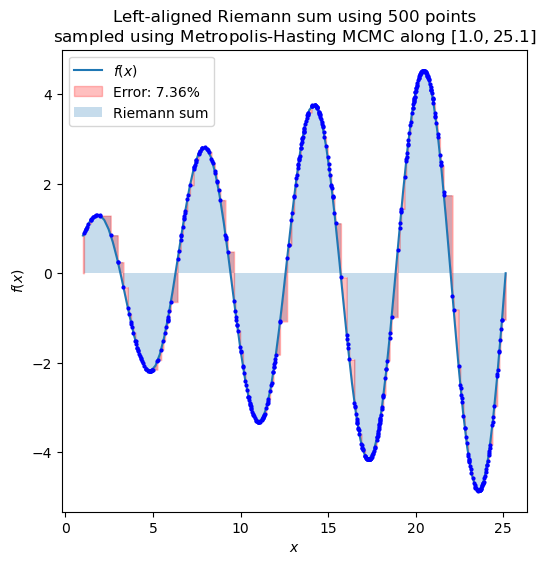

In [11]:
# This is our integrand. If the candidate x is out of our domain, we return 0
# to make A 0, ensuring that point is not chosen.
def f(x, domain):
    if domain[0] <= x <= domain[1]:
        return np.sin(x) * np.sqrt(x)
    else:
        return 0


def g(x_t, rng, x_prime=None):
    sigma = 16
    if x_prime is None:
        return rng.normal(loc=x_t, scale=sigma)
    else:
        return np.exp(-0.5 * ((x_prime - x_t) / sigma) ** 2) / (
            sigma * np.sqrt(2 * np.pi)
        )


result = run_and_plot_MHMC(
    f, g, (1, 8 * np.pi), -4.38857215564917, num_points=500, plot=True
)

We see that MHMC allows us to evaluate this integral numerically using importance sampling. Admittedly a large number of points is required to get a percent error that's comparable to that obtained by uniformly spacing samples.* But while uniformly spacing samples can't cope with the combinatorial explosion of many-dimensional integrals, MHMC can.
 
\* Uniformly spaced samples happen to work very well for this function due to its sinusoidal nature. For other functions, uniformly spaced samples would likely have a much higher percent error.